Predict Demanda_uni_equil

Referensi :
    [Ways to Detect and Remove the Outliers](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba)

<h1>1. Importing Packages</h1>

In [1]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd 

from sklearn import metrics
from sklearn.impute import SimpleImputer
from scipy.stats import norm
from scipy import stats
from scipy.stats import skew
from scipy import stats
from collections import Counter
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
client = pd.read_csv('csv/cliente_tabla.csv')
test = pd.read_csv('csv/df_test.csv')
train = pd.read_csv('csv/df_train.csv')
product = pd.read_csv('csv/producto_tabla.csv')
town = pd.read_csv('csv/town_state.csv')

In [3]:
# Check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

# Check data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (670000, 11) 
The test data size before dropping Id feature is : (330000, 11) 

The train data size after dropping Id feature is : (670000, 11) 
The test data size after dropping Id feature is : (330000, 11) 


In [4]:
train.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1656,1,1219,1446836,41938,4,39.64,0,0.0,4
1,8,4013,4,4912,62969,43118,13,132.73,0,0.0,13
2,3,1914,1,1107,2098200,1250,3,22.92,0,0.0,3
3,7,1470,1,2014,1525315,43316,3,24.45,0,0.0,3
4,6,2034,1,1288,2239746,1212,3,25.14,0,0.0,3


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670000 entries, 0 to 669999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Semana             670000 non-null  int64  
 1   Agencia_ID         670000 non-null  int64  
 2   Canal_ID           670000 non-null  int64  
 3   Ruta_SAK           670000 non-null  int64  
 4   Cliente_ID         670000 non-null  int64  
 5   Producto_ID        670000 non-null  int64  
 6   Venta_uni_hoy      670000 non-null  int64  
 7   Venta_hoy          670000 non-null  float64
 8   Dev_uni_proxima    670000 non-null  int64  
 9   Dev_proxima        670000 non-null  float64
 10  Demanda_uni_equil  670000 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 56.2 MB


In [6]:
train[['Venta_uni_hoy', 'Venta_hoy', 'Dev_uni_proxima', 'Dev_proxima', 'Demanda_uni_equil']].describe()

,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
count,670000.000000,670000.000000,670000.000000,670000.000000,670000.000000
mean,7.349776,68.379301,0.142752,1.314138,7.254504
std,24.037040,286.281299,10.767142,70.484346,22.241510
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,16.760000,0.000000,0.000000,2.000000
50%,3.000000,30.000000,0.000000,0.000000,3.000000
75%,7.000000,56.250000,0.000000,0.000000,6.000000
max,7200.000000,32470.000000,6768.000000,51840.000000,4380.000000


In [7]:
null_columns=train.columns[train.isnull().any()]
train[null_columns].isnull().sum()

Series([], dtype: float64)

In [8]:
# Checking Categorical Data
train.select_dtypes(include=['object']).columns

Index([], dtype='object')

In [9]:
# Checking Numerical Data
train.select_dtypes(include=['int64','float64']).columns

Index(['Semana', 'Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID',
       'Producto_ID', 'Venta_uni_hoy', 'Venta_hoy', 'Dev_uni_proxima',
       'Dev_proxima', 'Demanda_uni_equil'],
      dtype='object')

In [10]:
test.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,id
0,7,1130,1,1611,322306,35452,5,22.20,0,0.0,0
1,4,1350,1,2829,4489341,40680,2,13.72,0,0.0,1
2,6,1555,1,2815,2462099,43274,6,35.58,0,0.0,2
3,5,1439,1,2813,1096415,30572,8,50.00,0,0.0,3
4,9,2024,1,2116,5903035,35309,15,93.75,0,0.0,4


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330000 entries, 0 to 329999
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Semana           330000 non-null  int64  
 1   Agencia_ID       330000 non-null  int64  
 2   Canal_ID         330000 non-null  int64  
 3   Ruta_SAK         330000 non-null  int64  
 4   Cliente_ID       330000 non-null  int64  
 5   Producto_ID      330000 non-null  int64  
 6   Venta_uni_hoy    330000 non-null  int64  
 7   Venta_hoy        330000 non-null  float64
 8   Dev_uni_proxima  330000 non-null  int64  
 9   Dev_proxima      330000 non-null  float64
 10  id               330000 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 27.7 MB


In [12]:
test[['Venta_uni_hoy', 'Venta_hoy', 'Dev_uni_proxima', 'Dev_proxima']].describe()

,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima
count,330000.000000,330000.000000,330000.000000,330000.000000
mean,7.271045,67.786058,0.123348,1.238577
std,20.644295,286.310620,1.859310,22.668962
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,16.760000,0.000000,0.000000
50%,3.000000,30.000000,0.000000,0.000000
75%,6.000000,56.100000,0.000000,0.000000
max,3000.000000,36469.950000,420.000000,5854.800000


In [13]:
null_columns=test.columns[test.isnull().any()]
test[null_columns].isnull().sum()

Series([], dtype: float64)

In [14]:
# Checking Categorical Data
test.select_dtypes(include=['object']).columns

Index([], dtype='object')

In [15]:
# Checking Numerical Data
test.select_dtypes(include=['int64','float64']).columns

Index(['Semana', 'Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID',
       'Producto_ID', 'Venta_uni_hoy', 'Venta_hoy', 'Dev_uni_proxima',
       'Dev_proxima', 'id'],
      dtype='object')

In [16]:
num = len(train.select_dtypes(include=['int64','float64']).columns)
num_test = len(test.select_dtypes(include=['int64','float64']).columns)
print('Total Features in both Data: ', num, 'Features in Data Train', '+',
      num_test, 'Features in Data Test')

Total Features in both Data:  11 Features in Data Train + 11 Features in Data Test


<h2>Data Mix</h2>

In [17]:
data_mix = pd.concat([train,test],axis=0).reset_index(drop=True)
print('Size of df mix data', data_mix.shape)

Size of df mix data (1000000, 12)


<h2>Data Correlation</h2>

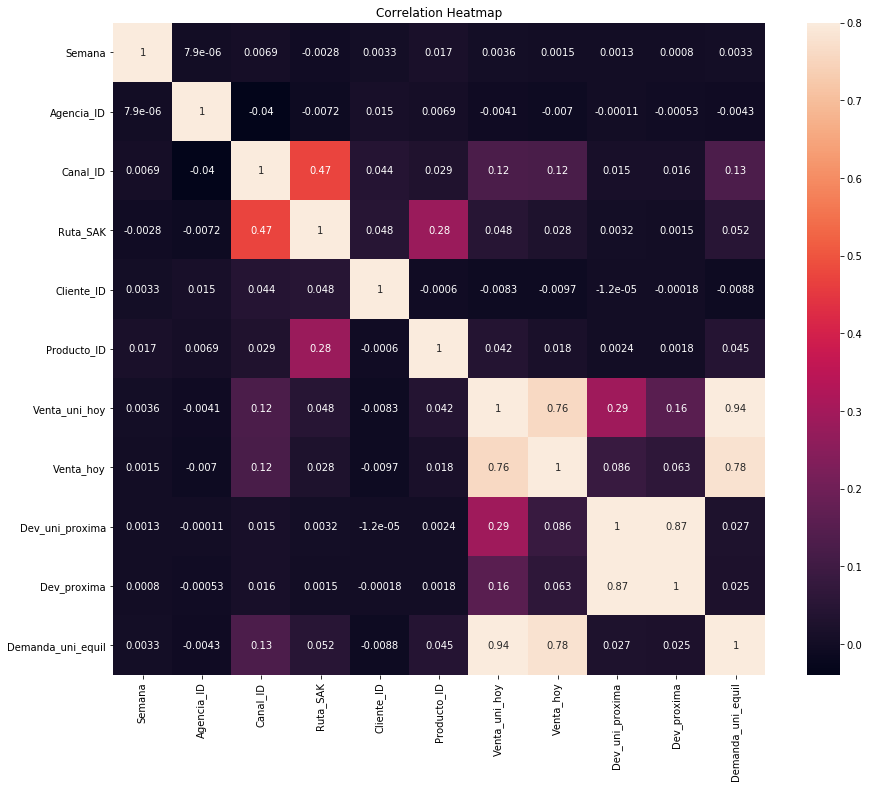

In [18]:
# Correlation Matrix Heatmap
cortrain = train.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(cortrain, vmax=.8, square=True, annot=True)
plt.title('Correlation Heatmap')
plt.savefig('fig/correlation_heatmap.png');

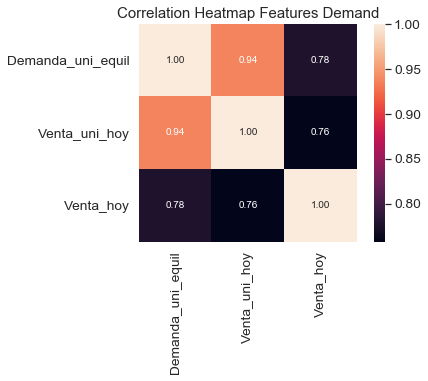

In [19]:
# Top Correlation
k = 3 #number of variables for heatmap
cols = cortrain.nlargest(k, 'Demanda_uni_equil')['Demanda_uni_equil'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.title('Correlation Heatmap Features Demand')
plt.savefig('fig/correlation_heatmap_demand.png')
# plt.show()

In [20]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,Demanda_uni_equil
1,Venta_uni_hoy
2,Venta_hoy


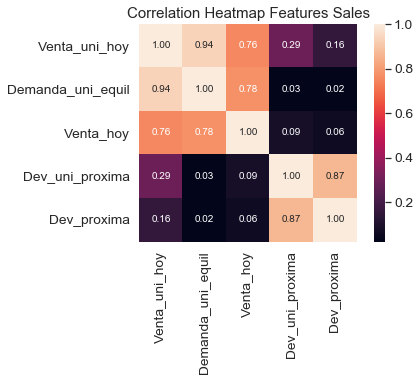

In [21]:
# Top Correlation
k = 5 #number of variables for heatmap
cols = cortrain.nlargest(k, 'Venta_uni_hoy')['Venta_uni_hoy'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.title('Correlation Heatmap Features Sales')
plt.savefig('fig/correlation_heatmap_sales.png')
# plt.show()

<h1>Data Exploration</h1>

<h2>Data Product</h2>

In [22]:
product.head()

,Producto_ID,NombreProducto
0,0,NO IDENTIFICADO 0
1,9,Capuccino Moka 750g NES 9
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41
3,53,Burritos Sincro 170g CU LON 53
4,72,Div Tira Mini Doradita 4p 45g TR 72


In [23]:
print('Size of Data Product', product.shape)

Size of Data Product (2592, 2)


In [24]:
print('Unique Product Id ' + str(len(product['Producto_ID'].unique())))

Unique Product Id 2592


In [25]:
product.isnull().sum()

Producto_ID       0
NombreProducto    0
dtype: int64

In [26]:
def get_product_agg(cols):
    df_train = pd.read_csv('csv/df_train.csv', usecols = ['Semana', 'Producto_ID'] + cols,
                           dtype  = {'Semana': 'int32',
                                     'Producto_ID':'int32',
                                     'Venta_hoy':'float32',
                                     'Venta_uni_hoy': 'int32',
                                     'Dev_uni_proxima':'int32',
                                     'Dev_proxima':'float32',
                                     'Demanda_uni_equil':'int32'})
    
    agg  = df_train.groupby(['Semana', 'Producto_ID'], as_index=False).agg(['count','sum', 'min', 'max','median','mean'])
    agg.columns  =  ['_'.join(col).strip() for col in agg.columns.values]
    del(df_train)
    return agg

In [27]:
#Demanda_uni_equil
agg1 = get_product_agg(['Demanda_uni_equil','Dev_uni_proxima','Venta_uni_hoy'])
agg1.head()

Venta_uni_hoy_count  Venta_uni_hoy_sum  Venta_uni_hoy_min  \
Semana Producto_ID                                                              
3      72                           154                781                  0   
       73                           290                695                  0   
       106                            6                 19                  2   
       107                            1                  2                  2   
       123                           16                112                  1   

                    Venta_uni_hoy_max  Venta_uni_hoy_median  \
Semana Producto_ID                                            
3      72                          25                   4.0   
       73                          28                   2.0   
       106                          7                   2.5   
       107                          2                   2.0   
       123                         25                   3.5   

                    Venta_uni_hoy_mean  Dev_uni_proxima_count  \
Semana Producto_ID                                              
3      72                     5.071429                    154   
       73                     2.396552                    290   
       106                    3.166667                      6   
       107                    2.000000                      1   
       123                    7.000000                     16   

                    Dev_uni_proxima_sum  Dev_uni_proxima_min  \
Semana Producto_ID                                             
3      72                            45                    0   
       73                            27                    0   
       106                            1                    0   
       107                            0                    0   
       123                            2                    0   

                    Dev_uni_proxima_max  Dev_uni_proxima_median  \
Semana Producto_ID                                                
3      72                            20                     0.0   
       73                             2                     0.0   
       106                            1                     0.0   
       107                            0                     0.0   
       123                            2                     0.0   

                    Dev_uni_proxima_mean  Demanda_uni_equil_count  \
Semana Producto_ID                                                  
3      72                       0.292208                      154   
       73                       0.093103                      290   
       106                      0.166667                        6   
       107                      0.000000                        1   
       123                      0.125000                       16   

                    Demanda_uni_equil_sum  Demanda_uni_equil_min  \
Semana Producto_ID                                                 
3      72                             769                      0   
       73                             670                      0   
       106                             18                      1   
       107                              2                      2   
       123                            111                      0   

                    Demanda_uni_equil_max  Demanda_uni_equil_median  \
Semana Producto_ID                                                    
3      72                              25                       4.0   
       73                              28                       2.0   
       106                              7                       2.5   
       107                              2                       2.0   
       123                             25                       3.5   

                    Demanda_uni_equil_mean  
Semana Producto_ID                          
3      72                         4.993506  
       73                         2.31034

In [28]:
data_product = (pd.merge(agg1.reset_index(), product, on='Producto_ID', how='left').
      groupby('NombreProducto')['Demanda_uni_equil_sum'].sum().sort_values(ascending=False))

Text(0.5, 1.0, 'Top 50 of Products Demand')

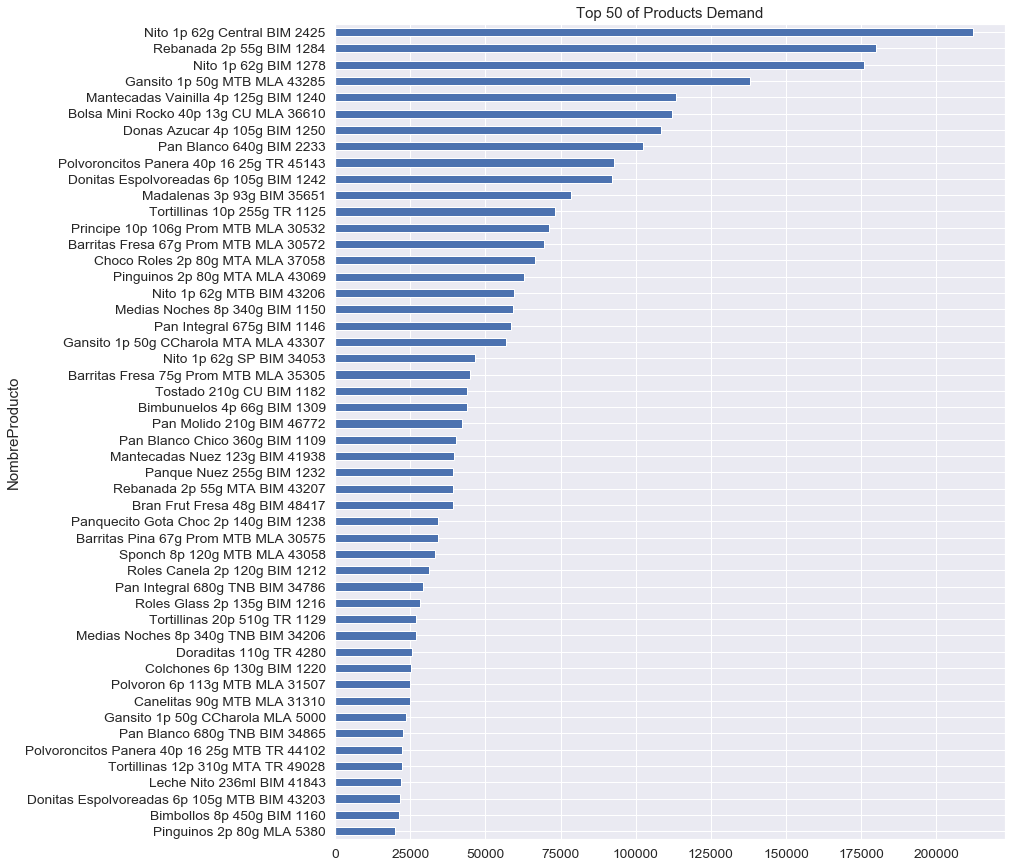

In [29]:
plt.figure(figsize = (12,15))
data_product.head(50).sort_values().plot(kind='barh')
plt.title("Top 50 of Products Demand")

<h4>Make Simple Name for Product</h4>

In [30]:
product['short_product_name'] = product['NombreProducto'].str.extract('^(\D*)', expand = False)
product['pieces'] = product['NombreProducto'].str.extract('(\d+)p ', expand = False).astype(float)
weight = product['NombreProducto'].str.extract('(\d+)(Kg|g)', expand = True)
product['weight'] = weight[0].astype('float') * weight[1].map({'Kg': 1000, 'g': 1})
product['brand'] = product['NombreProducto'].str.extract('^.+\s(\D+) \d+$')
product.head()

,Producto_ID,NombreProducto,short_product_name,pieces,weight,brand
0,0,NO IDENTIFICADO 0,NO IDENTIFICADO,NaN,NaN,IDENTIFICADO
1,9,Capuccino Moka 750g NES 9,Capuccino Moka,NaN,750.0,NES
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41,Bimbollos Ext sAjonjoli,6.0,480.0,BIM
3,53,Burritos Sincro 170g CU LON 53,Burritos Sincro,NaN,170.0,LON
4,72,Div Tira Mini Doradita 4p 45g TR 72,Div Tira Mini Doradita,4.0,45.0,TR


In [31]:
product_short_demand = (pd.merge(agg1.reset_index(), product, on='Producto_ID', how='left').
      groupby('short_product_name')['Demanda_uni_equil_sum'].sum().sort_values(ascending=False))
product_short_demand.head()

short_product_name
Nito            515948
Rebanada        240924
Gansito         236378
Pan Blanco      201361
Tortillinas     166081
Name: Demanda_uni_equil_sum, dtype: int32

Text(0.5, 1.0, 'Top 10 of Products Based on Demand')

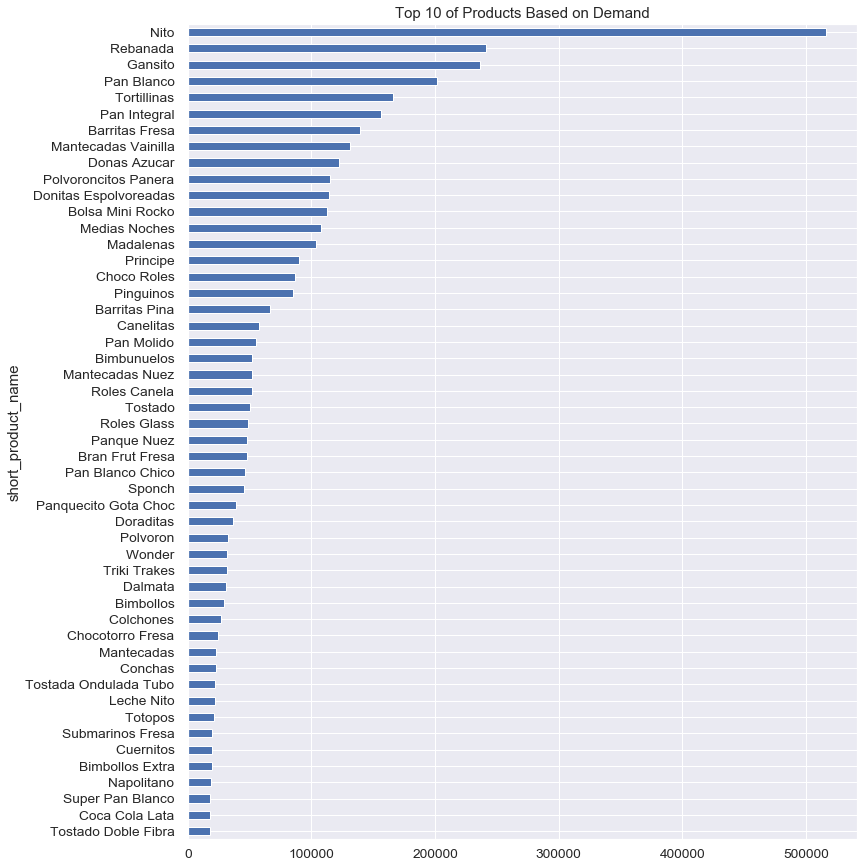

In [32]:
plt.figure(figsize = (12,15))
product_short_demand.head(50).sort_values().plot(kind='barh')
plt.title("Top 10 of Products Based on Demand")

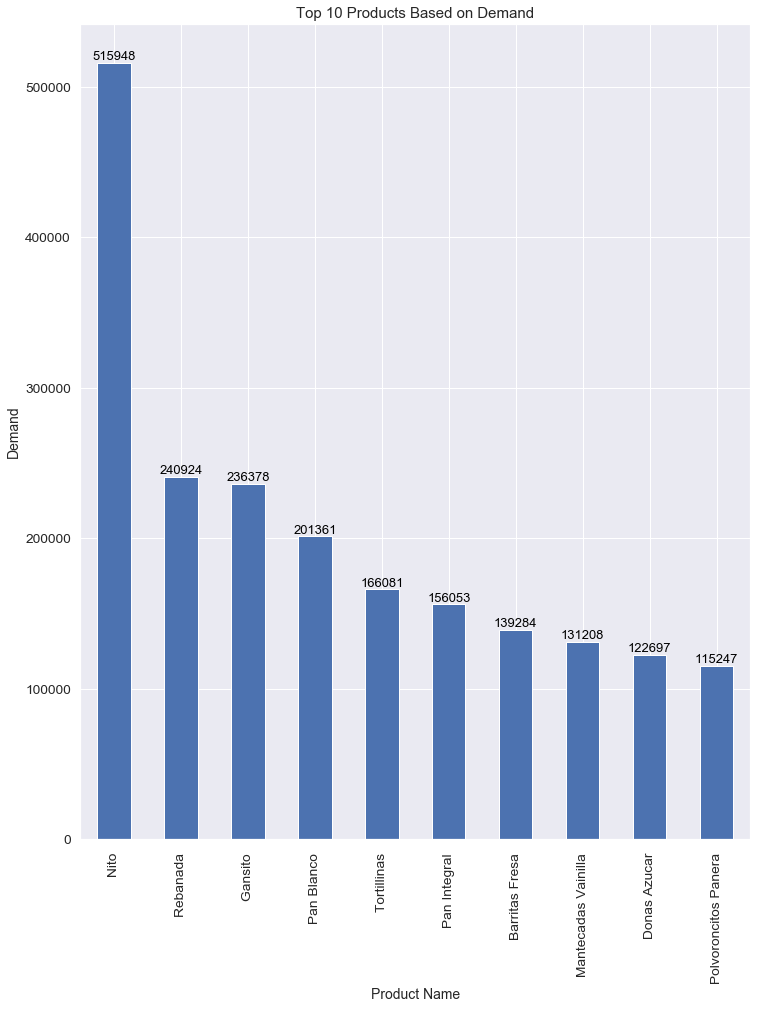

In [33]:
plt.figure(figsize = (12,15))

product_short_demand.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title("Top 10 Products Based on Demand")
plt.ylabel('Demand', fontsize=14) # y axis label
plt.xlabel('Product Name', fontsize=14) # x axis label

# Get current axis on current figure
ax = plt.gca()

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()),
           fontsize=13, color='black', ha='center', va='bottom')

plt.savefig("fig/Top10ProductsBasedonDemand.png")

In [34]:
product_short_sales = (pd.merge(agg1.reset_index(), product, on='Producto_ID', how='left').
      groupby('short_product_name')['Venta_uni_hoy_sum'].sum().sort_values(ascending=False))

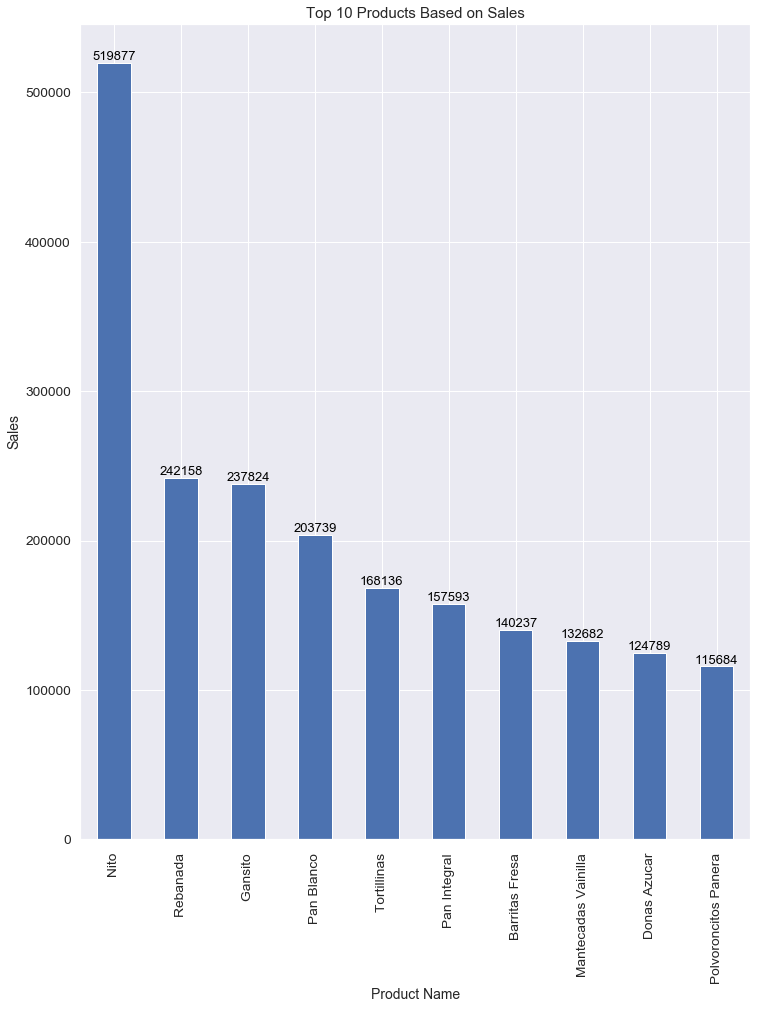

In [35]:
plt.figure(figsize = (12,15))

product_short_sales.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title("Top 10 Products Based on Sales")
plt.ylabel('Sales', fontsize=14) # y axis label
plt.xlabel('Product Name', fontsize=14) # x axis label

# Get current axis on current figure
ax = plt.gca()

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()),
           fontsize=13, color='black', ha='center', va='bottom')

# plt.savefig("fig/Top10ProductsBasedonSales.png")

In [36]:
product_short_return = (pd.merge(agg1.reset_index(), product, on='Producto_ID', how='left').
      groupby('short_product_name')['Dev_uni_proxima_sum'].sum().sort_values(ascending=False))

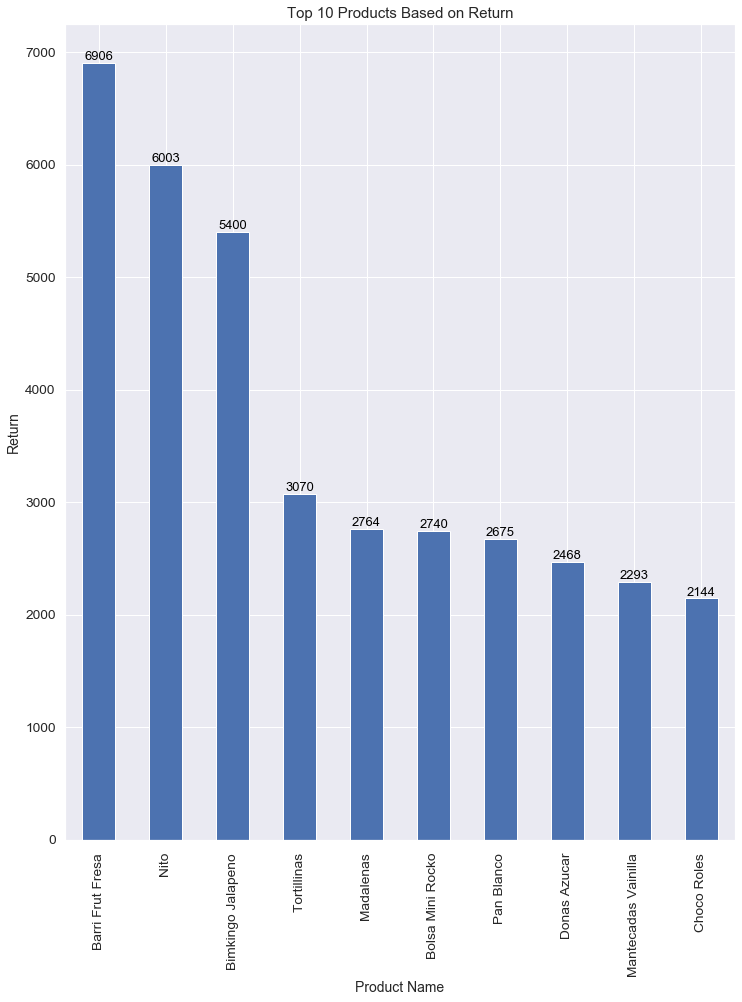

In [37]:
plt.figure(figsize = (12,15))

product_short_return.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title("Top 10 Products Based on Return")
plt.ylabel('Return', fontsize=14) # y axis label
plt.xlabel('Product Name', fontsize=14) # x axis label

# Get current axis on current figure
ax = plt.gca()

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()),
           fontsize=13, color='black', ha='center', va='bottom')

# plt.savefig("fig/Top10ProductsBasedonReturn.png")

In [38]:
# Find Nito
product[product.short_product_name == 'Nito ']

,Producto_ID,NombreProducto,short_product_name,pieces,weight,brand
115,1278,Nito 1p 62g BIM 1278,Nito,1.0,62.0,BIM
159,2425,Nito 1p 62g Central BIM 2425,Nito,1.0,62.0,BIM
262,5052,Nito 1p 62g Central TAB BIM 5052,Nito,1.0,62.0,BIM
756,32144,Nito 620g Cj MTB BIM 32144,Nito,NaN,620.0,BIM
1062,34053,Nito 1p 62g SP BIM 34053,Nito,1.0,62.0,BIM
1063,34054,Nito 1p 62g SP MTB BIM 34054,Nito,1.0,62.0,BIM
1064,34055,Nito 1p 62g SP TAB BIM 34055,Nito,1.0,62.0,BIM
1820,37159,Nito 1p 62g Central MTB BIM 37159,Nito,1.0,62.0,BIM
2135,43206,Nito 1p 62g MTB BIM 43206,Nito,1.0,62.0,BIM
2331,46132,Nito 1p 62g TAB BIM 46132,Nito,1.0,62.0,BIM


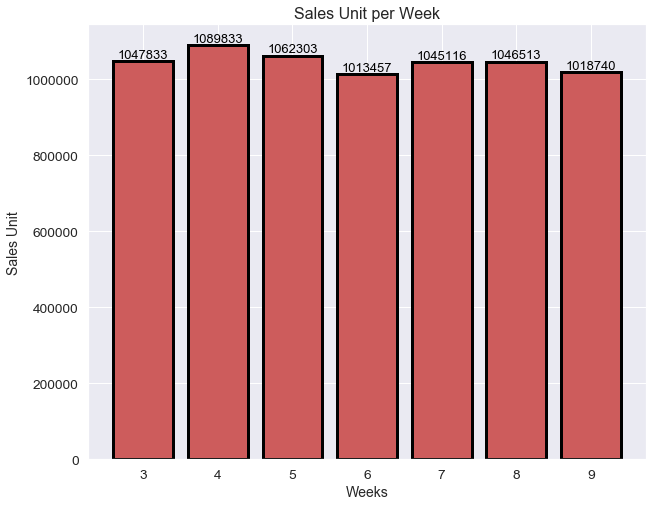

In [39]:
dfg = data_mix.groupby(['Semana'])['Venta_uni_hoy'].sum().reset_index(name='Venta_uni_hoy')

x = dfg['Semana']
y = dfg['Venta_uni_hoy']

plt.figure(figsize=(10,8))
barh = plt.bar(x=x, height=y, data=dfg, 
       color = 'indianred', # bar colors
       edgecolor= 'black', # edge bar colors
       linewidth = 3) # line width of bar
plt.title('Sales Unit per Week', fontsize = 16) #add title
plt.ylabel('Sales Unit', fontsize=14) # y axis label
plt.xlabel('Weeks', fontsize=14) # x axis label

# Get current axis on current figure
ax = plt.gca()

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()),
           fontsize=13, color='black', ha='center', va='bottom')

# plt.savefig("fig/SalesUnitPerWeek.png")

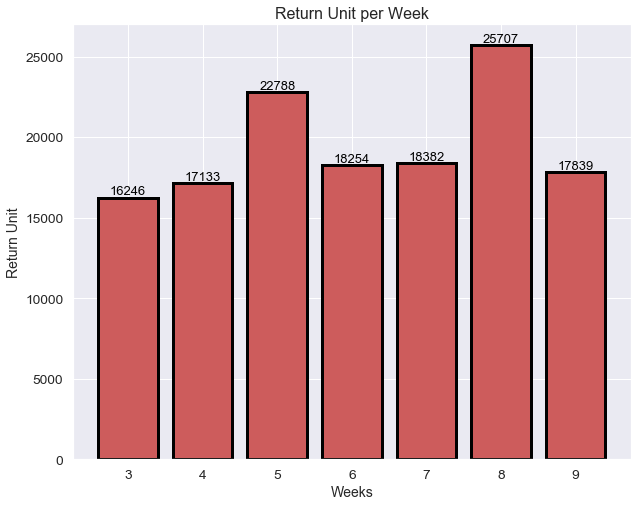

In [40]:
dfg = data_mix.groupby(['Semana'])['Dev_uni_proxima'].sum().reset_index(name='Dev_uni_proxima')

x = dfg['Semana']
y = dfg['Dev_uni_proxima']

plt.figure(figsize=(10,8))
barh = plt.bar(x=x, height=y, data=dfg, 
       color = 'indianred', # bar colors
       edgecolor= 'black', # edge bar colors
       linewidth = 3) # line width of bar
plt.title('Return Unit per Week', fontsize = 16) #add title
plt.ylabel('Return Unit', fontsize=14) # y axis label
plt.xlabel('Weeks', fontsize=14) # x axis label

# Get current axis on current figure
ax = plt.gca()

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()),
           fontsize=13, color='black', ha='center', va='bottom')

# plt.savefig("fig/ReturnUnitPerWeek.png")

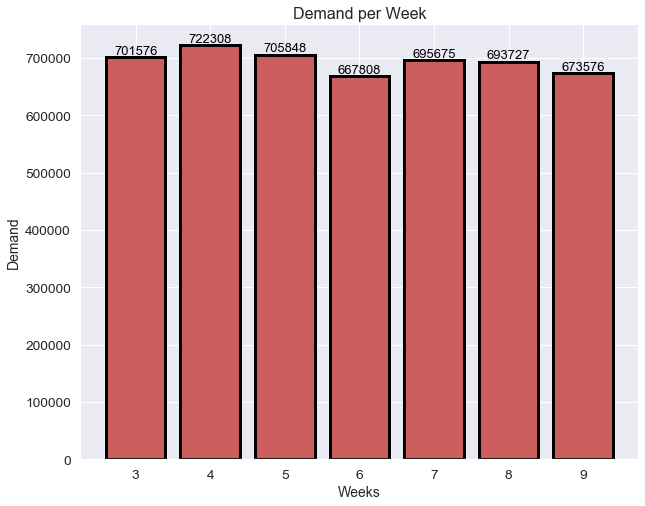

In [41]:
dfg = data_mix.groupby(['Semana'])['Demanda_uni_equil'].sum().reset_index(name='Demanda_uni_equil')

x = dfg['Semana']
y = dfg['Demanda_uni_equil']

plt.figure(figsize=(10,8))
barh = plt.bar(x=x, height=y, data=dfg, 
       color = 'indianred', # bar colors
       edgecolor= 'black', # edge bar colors
       linewidth = 3) # line width of bar
plt.title('Demand per Week', fontsize = 16) #add title
plt.ylabel('Demand', fontsize=14) # y axis label
plt.xlabel('Weeks', fontsize=14) # x axis label

# Get current axis on current figure
ax = plt.gca()

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()),
           fontsize=13, color='black', ha='center', va='bottom')
# plt.savefig("fig/DemandPerWeek.png")

<h1>Distribution of Data Train</h1>

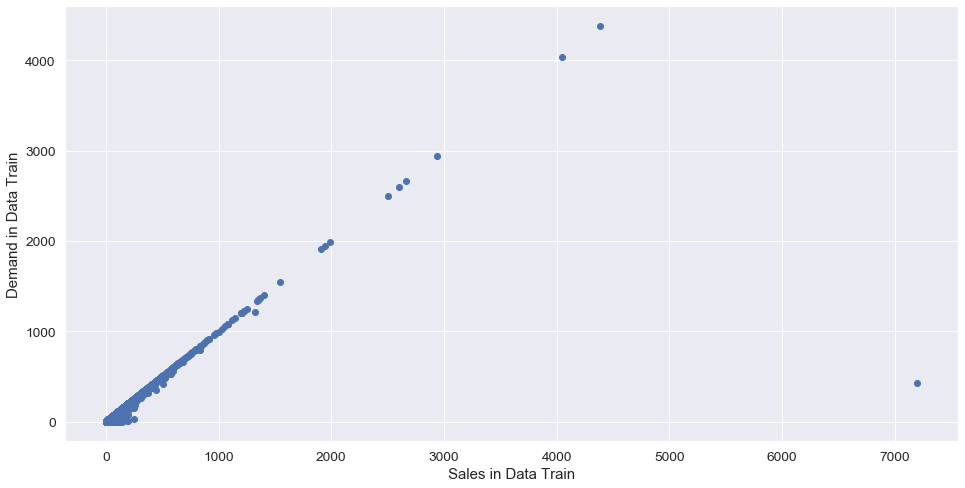

In [42]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(train['Venta_uni_hoy'], train['Demanda_uni_equil'])
ax.set_xlabel('Sales in Data Train')
ax.set_ylabel('Demand in Data Train')
# plt.savefig('fig/OutliersInTrain_Demand_Sales.png')
plt.show()

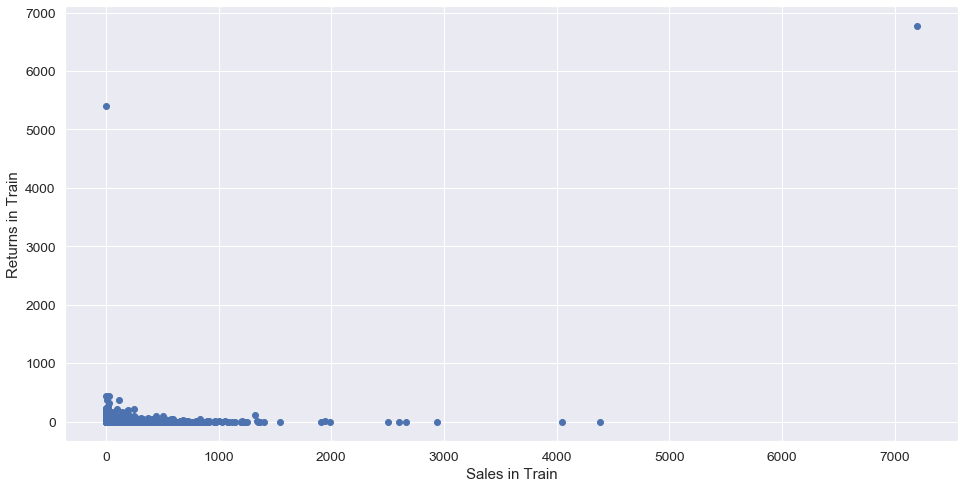

In [43]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(train['Venta_uni_hoy'], train['Dev_uni_proxima'])
ax.set_xlabel('Sales in Train')
ax.set_ylabel('Returns in Train')
# plt.savefig('fig/OutliersInTrain_Sales_Return.png')
plt.show()

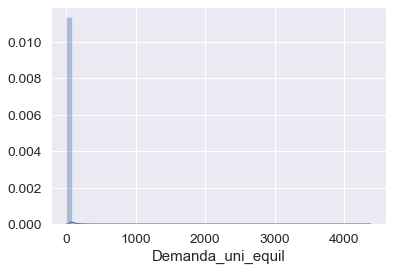

In [44]:
sns.distplot(train["Demanda_uni_equil"])

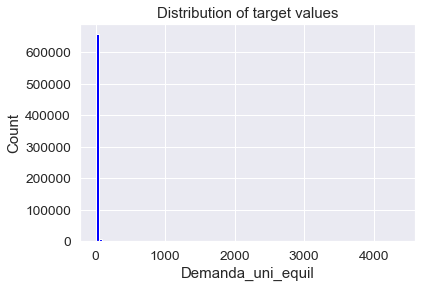

We have some pretty big outliers, let's zoom in and try again
Data with target values under 50: 133.97%


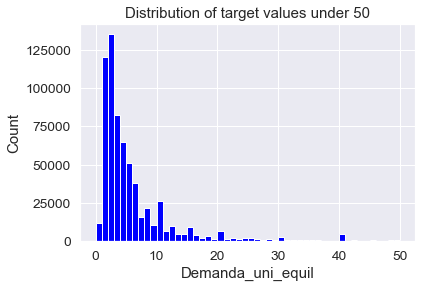

In [45]:
def label_plot(title, x, y):
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    
plt.hist(train['Demanda_uni_equil'], bins=100, color='blue')
label_plot('Distribution of target values', 'Demanda_uni_equil', 'Count')
# plt.savefig("fig/DistributionDemanda.png")
plt.show()

print("We have some pretty big outliers, let's zoom in and try again")

print('Data with target values under 50: ' + str(round(len(train.loc[train['Demanda_uni_equil'] <= 500]) / 5000, 2)) + '%')

plt.hist(train['Demanda_uni_equil'], bins=50, color='blue', range=(0, 50))
label_plot('Distribution of target values under 50', 'Demanda_uni_equil', 'Count')
# plt.savefig("fig/DistributionDemandaunder50.png")
plt.show()

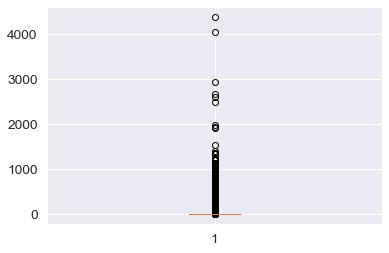

In [46]:
plt.boxplot(train['Demanda_uni_equil'])
# plt.savefig('fig/BoxplotDistribution.png')
plt.show()

In [47]:
print(train[['Venta_uni_hoy','Demanda_uni_equil','Dev_uni_proxima']].skew())

Venta_uni_hoy         78.216582
Demanda_uni_equil     47.988555
Dev_uni_proxima      559.528311
dtype: float64


In [48]:
train[['Venta_uni_hoy','Demanda_uni_equil', 'Dev_uni_proxima']].describe()

,Venta_uni_hoy,Demanda_uni_equil,Dev_uni_proxima
count,670000.000000,670000.000000,670000.000000
mean,7.349776,7.254504,0.142752
std,24.037040,22.241510,10.767142
min,0.000000,0.000000,0.000000
25%,2.000000,2.000000,0.000000
50%,3.000000,3.000000,0.000000
75%,7.000000,6.000000,0.000000
max,7200.000000,4380.000000,6768.000000


<h1>Missing Value</h1>

In [49]:
train_null = pd.isnull(train).sum()
test_null = pd.isnull(test).sum()

null = pd.concat([train_null, test_null], axis=1, keys=["Train", "Test"])

In [50]:
null_many = null[null.sum(axis=1) > 200]  #a lot of missing values
null_few = null[(null.sum(axis=1) > 0) & (null.sum(axis=1) < 200)]  #not as much missing values

In [51]:
null_many

,Train,Test


In [52]:
null_few

,Train,Test


<font color='Blue'>It indicates that there is no null in Data Train and Test</font>

<h1>Duplicates Value</h1>

In [53]:
print('Number of duplicated data in Data Test', test.duplicated().sum())
print('Number of duplicated data in Data Train', train.duplicated().sum())

Number of duplicated data in Data Test 0
Number of duplicated data in Data Train 0


<font color='Blue'>It indicates that there is no duplicates data in Data Train and Test</font>

<h1>Cutting Outlier</h1>

In [54]:
train.shape

(670000, 11)

<font color='red'>Formula for Z Score:
</br>
<b>Z Score = (Observation - Mean) / Standard Deviation</b></font>

In [55]:
from scipy import stats

z=np.abs(stats.zscore(train.Demanda_uni_equil))
print(z)

[0.14632581 0.25832328 0.19128682 ... 0.12344025 0.1013648  0.23624783]


<b>We find the z-score for each of the data point in the dataset and if the z-score is greater than 3 than we can classify that point as an outlier. Any point outside of 3 standard deviations would be an outlier.</b>

In [56]:
threshold=3
print(np.where(z > 3))

(array([   492,    565,    589, ..., 669532, 669809, 669909]),)


In [57]:
data_zscore = train
data_zscore['Demanda_uni_equil'] = train['Demanda_uni_equil'][(z < 3)]
data_zscore

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1656,1,1219,1446836,41938,4,39.64,0,0.0,4.0
1,8,4013,4,4912,62969,43118,13,132.73,0,0.0,13.0
2,3,1914,1,1107,2098200,1250,3,22.92,0,0.0,3.0
3,7,1470,1,2014,1525315,43316,3,24.45,0,0.0,3.0
4,6,2034,1,1288,2239746,1212,3,25.14,0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
669995,3,1119,1,1462,650938,1232,5,91.20,0,0.0,5.0
669996,5,2016,1,1328,4496395,2233,1,19.94,0,0.0,1.0
669997,9,4010,1,1258,1365659,43206,10,45.00,0,0.0,10.0
669998,4,4051,1,1106,122075,43197,5,41.90,0,0.0,5.0


In [58]:
data_zscore.shape

(670000, 11)

In [59]:
data_zscore.dropna()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1656,1,1219,1446836,41938,4,39.64,0,0.0,4.0
1,8,4013,4,4912,62969,43118,13,132.73,0,0.0,13.0
2,3,1914,1,1107,2098200,1250,3,22.92,0,0.0,3.0
3,7,1470,1,2014,1525315,43316,3,24.45,0,0.0,3.0
4,6,2034,1,1288,2239746,1212,3,25.14,0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
669995,3,1119,1,1462,650938,1232,5,91.20,0,0.0,5.0
669996,5,2016,1,1328,4496395,2233,1,19.94,0,0.0,1.0
669997,9,4010,1,1258,1365659,43206,10,45.00,0,0.0,10.0
669998,4,4051,1,1106,122075,43197,5,41.90,0,0.0,5.0


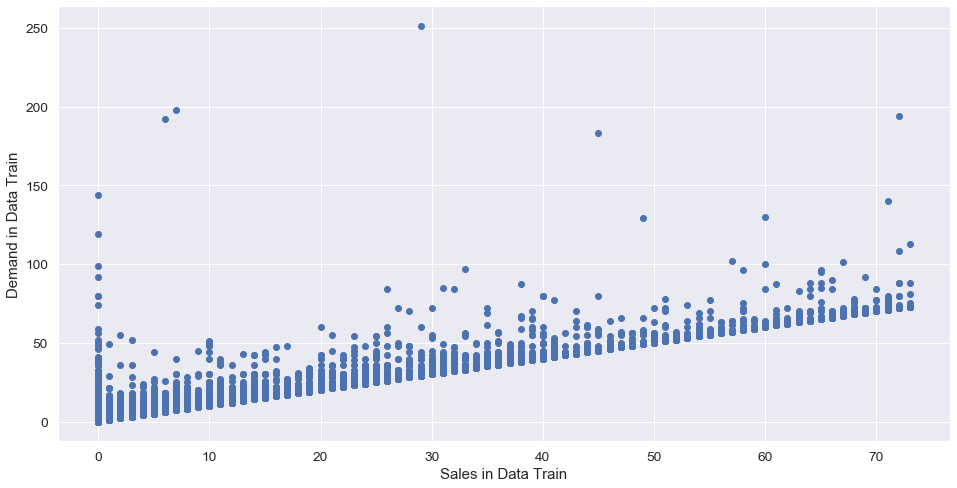

In [60]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(train['Demanda_uni_equil'], train['Venta_uni_hoy'])
ax.set_xlabel('Sales in Data Train')
ax.set_ylabel('Demand in Data Train')
# plt.savefig('fig/OutliersInTrain_after_drop.png')
plt.show()

In [61]:
zsales=np.abs(stats.zscore(train.Venta_uni_hoy))
print(zsales)

[0.13935903 0.23506339 0.18096152 ... 0.11025591 0.09775654 0.22256401]


In [62]:
data_zscore_sales = train
data_zscore_sales['Venta_uni_hoy'] = data_zscore['Venta_uni_hoy'][(zsales < 3)]
data_zscore_sales

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1656,1,1219,1446836,41938,4.0,39.64,0,0.0,4.0
1,8,4013,4,4912,62969,43118,13.0,132.73,0,0.0,13.0
2,3,1914,1,1107,2098200,1250,3.0,22.92,0,0.0,3.0
3,7,1470,1,2014,1525315,43316,3.0,24.45,0,0.0,3.0
4,6,2034,1,1288,2239746,1212,3.0,25.14,0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
669995,3,1119,1,1462,650938,1232,5.0,91.20,0,0.0,5.0
669996,5,2016,1,1328,4496395,2233,1.0,19.94,0,0.0,1.0
669997,9,4010,1,1258,1365659,43206,10.0,45.00,0,0.0,10.0
669998,4,4051,1,1106,122075,43197,5.0,41.90,0,0.0,5.0


In [64]:
train_clean = data_zscore_sales.dropna()
train_clean

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1656,1,1219,1446836,41938,4.0,39.64,0,0.0,4.0
1,8,4013,4,4912,62969,43118,13.0,132.73,0,0.0,13.0
2,3,1914,1,1107,2098200,1250,3.0,22.92,0,0.0,3.0
3,7,1470,1,2014,1525315,43316,3.0,24.45,0,0.0,3.0
4,6,2034,1,1288,2239746,1212,3.0,25.14,0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
669995,3,1119,1,1462,650938,1232,5.0,91.20,0,0.0,5.0
669996,5,2016,1,1328,4496395,2233,1.0,19.94,0,0.0,1.0
669997,9,4010,1,1258,1365659,43206,10.0,45.00,0,0.0,10.0
669998,4,4051,1,1106,122075,43197,5.0,41.90,0,0.0,5.0


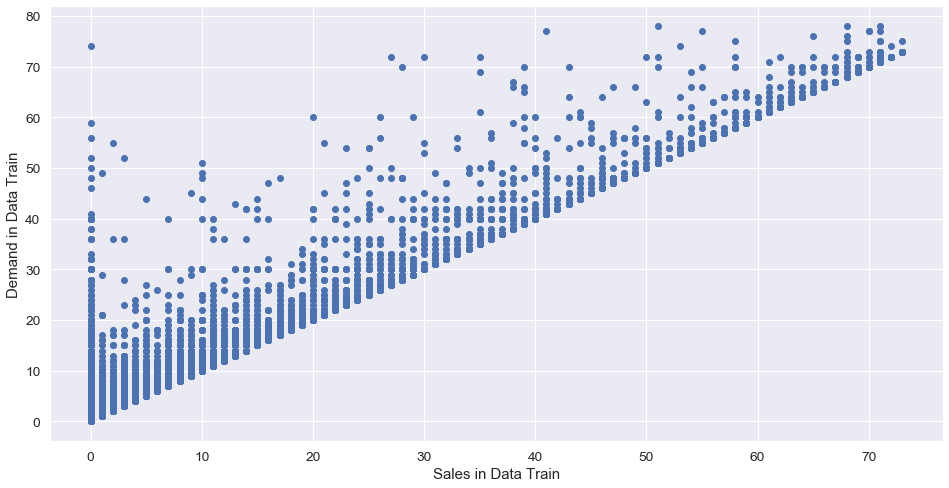

In [65]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(train_clean['Demanda_uni_equil'], train_clean['Venta_uni_hoy'])
ax.set_xlabel('Sales in Data Train')
ax.set_ylabel('Demand in Data Train')
# plt.savefig('fig/OutliersInTrainAfterCleanTheOutliersInSales.png')
plt.show()

In [66]:
print(train_clean[['Venta_uni_hoy','Demanda_uni_equil','Dev_uni_proxima']].skew())

Venta_uni_hoy          3.593585
Demanda_uni_equil      3.582306
Dev_uni_proxima      738.637805
dtype: float64


In [67]:
train_clean[['Venta_uni_hoy','Demanda_uni_equil','Dev_uni_proxima']].describe()

,Venta_uni_hoy,Demanda_uni_equil,Dev_uni_proxima
count,664259.000000,664259.000000,664259.000000
mean,6.038009,5.967967,0.117298
std,8.185477,8.150639,6.851991
min,0.000000,0.000000,0.000000
25%,2.000000,2.000000,0.000000
50%,3.000000,3.000000,0.000000
75%,6.000000,6.000000,0.000000
max,78.000000,73.000000,5400.000000


In [68]:
train_null = pd.isnull(train_clean).sum()
test_null = pd.isnull(test).sum()

null = pd.concat([train_null, test_null], axis=1, keys=["Train", "Test"])

print(train_null)
# print(test_null)

Semana               0
Agencia_ID           0
Canal_ID             0
Ruta_SAK             0
Cliente_ID           0
Producto_ID          0
Venta_uni_hoy        0
Venta_hoy            0
Dev_uni_proxima      0
Dev_proxima          0
Demanda_uni_equil    0
dtype: int64


<h1>Joining Table</h1>

In [69]:
data_mix = pd.concat([train_clean,test],axis=0).reset_index(drop=True)
print('Size of Data Mix between Train and Test', data_mix.shape)

Size of Data Mix between Train and Test (994259, 12)


In [70]:
data_mix.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,id
0,3,1656,1,1219,1446836,41938,4.0,39.64,0,0.0,4.0,NaN
1,8,4013,4,4912,62969,43118,13.0,132.73,0,0.0,13.0,NaN
2,3,1914,1,1107,2098200,1250,3.0,22.92,0,0.0,3.0,NaN
3,7,1470,1,2014,1525315,43316,3.0,24.45,0,0.0,3.0,NaN
4,6,2034,1,1288,2239746,1212,3.0,25.14,0,0.0,3.0,NaN


In [71]:
data_mix.tail()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,id
994254,8,1340,1,2058,1014894,43285,25.0,132.00,0,0.00,NaN,329995.0
994255,9,2021,1,1217,9559665,1160,1.0,18.86,1,18.86,NaN,329996.0
994256,3,23719,1,1163,2221814,1250,5.0,38.20,0,0.00,NaN,329997.0
994257,9,1349,1,1131,905631,8940,3.0,24.00,0,0.00,NaN,329998.0
994258,5,1637,1,4412,748310,43316,1.0,8.15,0,0.00,NaN,329999.0


In [72]:
data_mix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994259 entries, 0 to 994258
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Semana             994259 non-null  int64  
 1   Agencia_ID         994259 non-null  int64  
 2   Canal_ID           994259 non-null  int64  
 3   Ruta_SAK           994259 non-null  int64  
 4   Cliente_ID         994259 non-null  int64  
 5   Producto_ID        994259 non-null  int64  
 6   Venta_uni_hoy      994259 non-null  float64
 7   Venta_hoy          994259 non-null  float64
 8   Dev_uni_proxima    994259 non-null  int64  
 9   Dev_proxima        994259 non-null  float64
 10  Demanda_uni_equil  664259 non-null  float64
 11  id                 330000 non-null  float64
dtypes: float64(5), int64(7)
memory usage: 91.0 MB


In [73]:
data_mix['id'] = data_mix['id'].astype('Int64')

In [74]:
data_mix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994259 entries, 0 to 994258
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Semana             994259 non-null  int64  
 1   Agencia_ID         994259 non-null  int64  
 2   Canal_ID           994259 non-null  int64  
 3   Ruta_SAK           994259 non-null  int64  
 4   Cliente_ID         994259 non-null  int64  
 5   Producto_ID        994259 non-null  int64  
 6   Venta_uni_hoy      994259 non-null  float64
 7   Venta_hoy          994259 non-null  float64
 8   Dev_uni_proxima    994259 non-null  int64  
 9   Dev_proxima        994259 non-null  float64
 10  Demanda_uni_equil  664259 non-null  float64
 11  id                 330000 non-null  Int64  
dtypes: Int64(1), float64(4), int64(7)
memory usage: 92.0 MB


<h1>Split Train and Test</h1>

In [75]:
train_2 = data_mix[data_mix['Demanda_uni_equil'].notnull()].drop(['id'], axis=1)
train_2

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1656,1,1219,1446836,41938,4.0,39.64,0,0.0,4.0
1,8,4013,4,4912,62969,43118,13.0,132.73,0,0.0,13.0
2,3,1914,1,1107,2098200,1250,3.0,22.92,0,0.0,3.0
3,7,1470,1,2014,1525315,43316,3.0,24.45,0,0.0,3.0
4,6,2034,1,1288,2239746,1212,3.0,25.14,0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
664254,3,1119,1,1462,650938,1232,5.0,91.20,0,0.0,5.0
664255,5,2016,1,1328,4496395,2233,1.0,19.94,0,0.0,1.0
664256,9,4010,1,1258,1365659,43206,10.0,45.00,0,0.0,10.0
664257,4,4051,1,1106,122075,43197,5.0,41.90,0,0.0,5.0


In [76]:
test_2 = data_mix[data_mix['Demanda_uni_equil'].isnull()].drop(['Demanda_uni_equil'], axis=1)
test_2

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,id
664259,7,1130,1,1611,322306,35452,5.0,22.20,0,0.00,0
664260,4,1350,1,2829,4489341,40680,2.0,13.72,0,0.00,1
664261,6,1555,1,2815,2462099,43274,6.0,35.58,0,0.00,2
664262,5,1439,1,2813,1096415,30572,8.0,50.00,0,0.00,3
664263,9,2024,1,2116,5903035,35309,15.0,93.75,0,0.00,4
...,...,...,...,...,...,...,...,...,...,...,...
994254,8,1340,1,2058,1014894,43285,25.0,132.00,0,0.00,329995
994255,9,2021,1,1217,9559665,1160,1.0,18.86,1,18.86,329996
994256,3,23719,1,1163,2221814,1250,5.0,38.20,0,0.00,329997
994257,9,1349,1,1131,905631,8940,3.0,24.00,0,0.00,329998


In [77]:
test_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330000 entries, 664259 to 994258
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Semana           330000 non-null  int64  
 1   Agencia_ID       330000 non-null  int64  
 2   Canal_ID         330000 non-null  int64  
 3   Ruta_SAK         330000 non-null  int64  
 4   Cliente_ID       330000 non-null  int64  
 5   Producto_ID      330000 non-null  int64  
 6   Venta_uni_hoy    330000 non-null  float64
 7   Venta_hoy        330000 non-null  float64
 8   Dev_uni_proxima  330000 non-null  int64  
 9   Dev_proxima      330000 non-null  float64
 10  id               330000 non-null  Int64  
dtypes: Int64(1), float64(3), int64(7)
memory usage: 30.5 MB


<h1>Number of Demand</h1>

In [78]:
data_mix['Demanda_uni_equil'].value_counts(normalize=True,dropna=False)

NaN     0.331905
2.0     0.135945
1.0     0.120731
3.0     0.083121
4.0     0.065031
          ...   
69.0    0.000089
68.0    0.000082
67.0    0.000074
71.0    0.000068
73.0    0.000048
Name: Demanda_uni_equil, Length: 75, dtype: float64

<h1>Modelling</h1>

In [79]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score, KFold

<h1>Linear Regression</h1>

In [93]:
x=train_2[['Venta_uni_hoy', 'Dev_uni_proxima']]
y=train_2['Demanda_uni_equil']
x_test=test_2[['Venta_uni_hoy', 'Dev_uni_proxima']]

In [266]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.3,random_state=4)

In [267]:
regressor=LinearRegression()
regressor.fit(xtrain,ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [268]:
pred=regressor.predict(xtest)
pred

array([ 6.922967  ,  0.97259613,  2.95605309, ..., 36.67482132,
        0.97259613,  0.97259613])

In [269]:
#y=a+bx, Intercept = a
print('Intercept:\n',regressor.intercept_)

Intercept:
 -0.019132343952360742


In [270]:
#y=a+bx, Coefficient = b
print('Coefficients:\n',regressor.coef_)

Coefficients:
 [ 0.99172848 -0.01117881]


In [271]:
pred.shape

(199278,)

In [272]:
from sklearn.metrics import mean_squared_error
print("Mean squared error:%.2f"% mean_squared_error(ytest,pred))

Mean squared error:0.53


In [273]:
rmse = np.sqrt(mean_squared_error(ytest, pred))
print("RMSE:%.2f"% rmse)

RMSE:0.73


In [274]:
regressor.score(xtest,ytest)

0.9919438051548369

In [275]:
xtest.shape

(199278, 2)

In [276]:
xtest

,Venta_uni_hoy,Dev_uni_proxima
635623,7.0,0
489082,1.0,0
6157,3.0,0
491067,20.0,0
5095,3.0,0
...,...,...
78040,3.0,0
495187,3.0,0
500706,37.0,0
45866,1.0,0


In [277]:
prediction = regressor.predict(x_test)
prediction

array([4.93951004, 1.96432461, 5.93123852, ..., 4.93951004, 2.95605309,
       0.97259613])

In [219]:
x_test

,Venta_uni_hoy,Dev_uni_proxima
664259,5.0,0
664260,2.0,0
664261,6.0,0
664262,8.0,0
664263,15.0,0
...,...,...
994254,25.0,0
994255,1.0,1
994256,5.0,0
994257,3.0,0


<h1>XGBoost Regressor</h1>

In [220]:
from xgboost import XGBRegressor

xgb = XGBRegressor()

xgb.fit(xtrain,ytrain)

[19:08:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [221]:
pred_2 = xgb.predict(xtest)
pred_2

array([ 2.0011547,  2.0011547,  3.9992878, ...,  2.0011547,  1.0064943,
       15.990339 ], dtype=float32)

In [222]:
from sklearn.metrics import mean_squared_error
print("Mean squared error:%.2f"% mean_squared_error(ytest,pred_2))

Mean squared error:0.01


In [223]:
rmse = np.sqrt(mean_squared_error(ytest, pred_2))
print("RMSE:%.2f"% rmse)

RMSE:0.08


In [224]:
prediction_2 = xgb.predict(x_test)

In [226]:
rmse = np.sqrt(mean_squared_error(prediction, prediction_2))
print("RMSE:%.2f"% rmse)

RMSE:15.19


<h1>Ridge</h1>

In [227]:
from sklearn.linear_model import RidgeCV

regressor1 = RidgeCV(alphas=[1, 1e3, 1e6], store_cv_values=True)
regressor1.fit(xtrain, ytrain)
cv_mse = np.mean(regressor1.cv_values_, axis=0)
cv_mse

array([4.14525227, 4.14003398, 1.79624666])

In [228]:
prediction3 = regressor1.predict(x_test)
prediction3

array([4.97227099, 2.08957545, 5.93316951, ..., 4.97227099, 3.05047396,
       1.12867693])

In [229]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(random_state=88)
ridge_model.fit(xtrain, ytrain)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=88, solver='auto', tol=0.001)

In [230]:
pred_3 = ridge_model.predict(xtest)
pred_3

array([ 1.96568712,  1.96568712,  3.94868121, ...,  1.96568712,
        0.97419007, 15.84664574])

In [231]:
from sklearn.metrics import mean_squared_error
print("Mean squared error:%.2f"% mean_squared_error(ytest,pred_3))

rmse = np.sqrt(mean_squared_error(ytest, pred_3))
print("RMSE:%.2f"% rmse)

Mean squared error:0.52
RMSE:0.72


In [232]:
prediction_3 = ridge_model.predict(x_test)
prediction_3

array([4.94017825, 1.96568712, 5.93167529, ..., 4.94017825, 2.95718416,
       0.97419007])

<h1>Lasso</h1>

In [233]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(random_state=88)
lasso_model.fit(xtrain, ytrain)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=88,
      selection='cyclic', tol=0.0001, warm_start=False)

In [234]:
#Predicting the prices
pred_4 = lasso_model.predict(xtest)
pred_4

array([ 2.02461748,  2.02461748,  3.97785526, ...,  2.02461748,
        1.04799858, 15.69728198])

In [235]:
from sklearn.metrics import mean_squared_error
print("Mean squared error:%.2f"% mean_squared_error(ytest,pred_4))

rmse = np.sqrt(mean_squared_error(ytest, pred_4))
print("RMSE:%.2f"% rmse)

Mean squared error:0.55
RMSE:0.74


In [236]:
prediction_4 = lasso_model.predict(x_test)
prediction_4

array([4.95447415, 2.02461748, 5.93109305, ..., 4.95447415, 3.00123637,
       1.04799858])

<h1>K-Fold Cross Validation</1>

In [278]:
kf = KFold(n_splits=10,shuffle=False)
model = LinearRegression()
result = model_selection.cross_val_score(model, xtrain, ytrain, cv=kf)
print("Accuracy: %.3f%% (%.3f%%)" % (result.mean()*100.0, result.std()*100.0))

Accuracy: 95.149% (12.087%)


In [279]:
test_2['Predicted']=prediction
data_submit = test_2[['id', 'Predicted']]
data_submit = data_submit.set_index('id')
data_submit
# data_submit.to_csv('upload_kaggle/submission_linear_random_state_4.csv')

,Predicted
id,
0,4.939510
1,1.964325
2,5.931239
3,7.914695
4,14.856795
...,...
329995,24.774080
329996,0.961417
329997,4.939510


<h1>The Results</h1>

In [297]:
test_2.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,id,Predicted
664259,7,1130,1,1611,322306,35452,5.0,22.20,0,0.0,0,4.939510
664260,4,1350,1,2829,4489341,40680,2.0,13.72,0,0.0,1,1.964325
664261,6,1555,1,2815,2462099,43274,6.0,35.58,0,0.0,2,5.931239
664262,5,1439,1,2813,1096415,30572,8.0,50.00,0,0.0,3,7.914695
664263,9,2024,1,2116,5903035,35309,15.0,93.75,0,0.0,4,14.856795


In [298]:
test_2.tail()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,id,Predicted
994254,8,1340,1,2058,1014894,43285,25.0,132.00,0,0.00,329995,24.774080
994255,9,2021,1,1217,9559665,1160,1.0,18.86,1,18.86,329996,0.961417
994256,3,23719,1,1163,2221814,1250,5.0,38.20,0,0.00,329997,4.939510
994257,9,1349,1,1131,905631,8940,3.0,24.00,0,0.00,329998,2.956053
994258,5,1637,1,4412,748310,43316,1.0,8.15,0,0.00,329999,0.972596


In [294]:
the_result = test_2.to_csv('csv/the_result.csv')

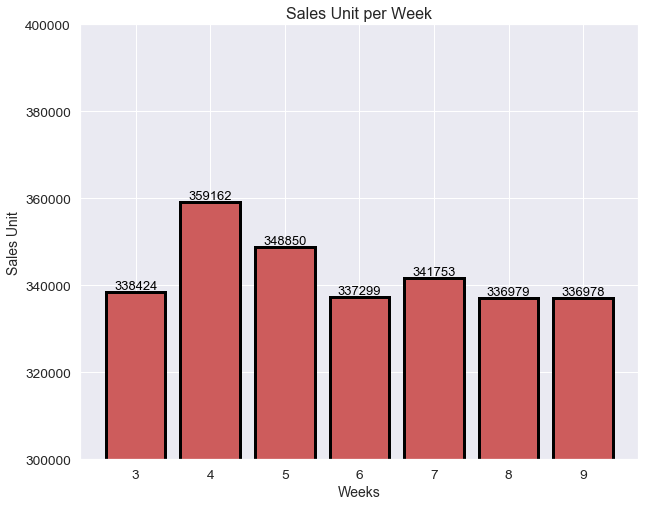

In [288]:
dfg = test_2.groupby(['Semana'])['Venta_uni_hoy'].sum().reset_index(name='Venta_uni_hoy')

x = dfg['Semana']
y = dfg['Venta_uni_hoy']

plt.figure(figsize=(10,8))
barh = plt.bar(x=x, height=y, data=dfg, 
       color = 'indianred', # bar colors
       edgecolor= 'black', # edge bar colors
       linewidth = 3) # line width of bar
plt.title('Sales Unit per Week', fontsize = 16) #add title
plt.ylabel('Sales Unit', fontsize=14) # y axis label
plt.ylim((300000,400000))
plt.xlabel('Weeks', fontsize=14) # x axis label

# Get current axis on current figure
ax = plt.gca()

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()),
           fontsize=13, color='black', ha='center', va='bottom')

plt.savefig("fig/SalesUnitPerWeekinTest.png")

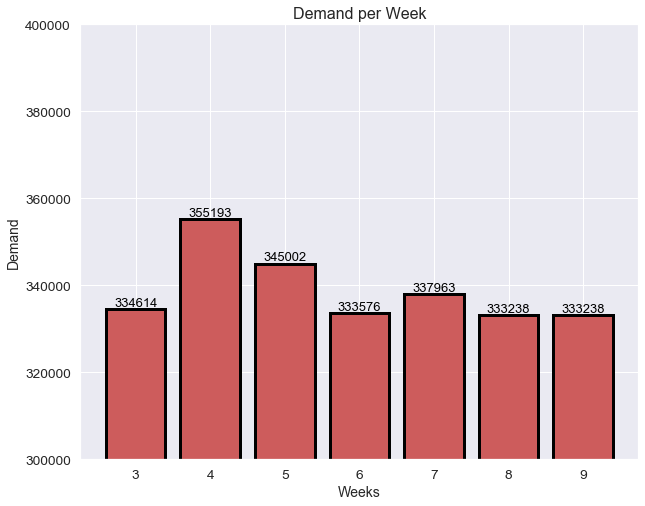

In [289]:
dfg = test_2.groupby(['Semana'])['Predicted'].sum().reset_index(name='Predicted')

x = dfg['Semana']
y = dfg['Predicted']

plt.figure(figsize=(10,8))
barh = plt.bar(x=x, height=y, data=dfg, 
       color = 'indianred', # bar colors
       edgecolor= 'black', # edge bar colors
       linewidth = 3) # line width of bar
plt.title('Demand per Week', fontsize = 16) #add title
plt.ylabel('Demand', fontsize=14) # y axis label
plt.ylim((300000,400000))
plt.xlabel('Weeks', fontsize=14) # x axis label

# Get current axis on current figure
ax = plt.gca()

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()),
           fontsize=13, color='black', ha='center', va='bottom')

plt.savefig("fig/DemandPerWeekinTest.png")

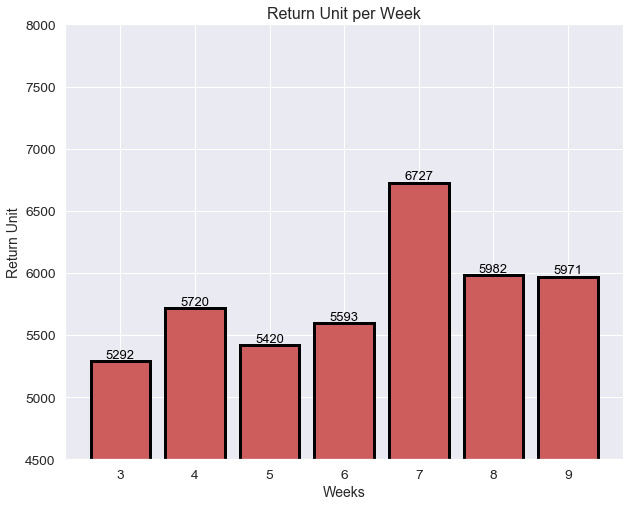

In [304]:
dfg = test_2.groupby(['Semana'])['Dev_uni_proxima'].sum().reset_index(name='Dev_uni_proxima')

x = dfg['Semana']
y = dfg['Dev_uni_proxima']

plt.figure(figsize=(10,8))
barh = plt.bar(x=x, height=y, data=dfg, 
       color = 'indianred', # bar colors
       edgecolor= 'black', # edge bar colors
       linewidth = 3) # line width of bar
plt.title('Return Unit per Week', fontsize = 16) #add title
plt.ylabel('Return Unit', fontsize=14) # y axis label
plt.ylim((4500,8000))
plt.xlabel('Weeks', fontsize=14) # x axis label

# Get current axis on current figure
ax = plt.gca()

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()),
           fontsize=13, color='black', ha='center', va='bottom')

plt.savefig("fig/ReturnUnitPerWeekinTest.png")

In [299]:
def get_product_agg_test(cols):
    data_test = pd.read_csv('csv/the_result.csv', usecols = ['Semana', 'Producto_ID'] + cols,
                           dtype  = {'Semana': 'int32',
                                     'Producto_ID':'int32',
                                     'Venta_hoy':'float32',
                                     'Venta_uni_hoy': 'int32',
                                     'Dev_uni_proxima':'int32',
                                     'Dev_proxima':'float32',
                                     'Demanda_uni_equil':'int32'})
    
    agg_test  = data_test.groupby(['Semana', 'Producto_ID'], as_index=False).agg(['count','sum', 'min', 'max','median','mean'])
    agg_test.columns  =  ['_'.join(col).strip() for col in agg_test.columns.values]
    del(data_test)
    return agg_test

In [300]:
#Demanda_uni_equil
agg_test_1 = get_product_agg_test(['Predicted','Dev_uni_proxima','Venta_uni_hoy'])
agg_test_1.head()

Venta_uni_hoy_count  Venta_uni_hoy_sum  Venta_uni_hoy_min  \
Semana Producto_ID                                                              
3      72                            91                428                  1   
       73                           143                467                  0   
       106                            2                 77                 14   
       123                           10                125                  1   
       134                            1                 12                 12   

                    Venta_uni_hoy_max  Venta_uni_hoy_median  \
Semana Producto_ID                                            
3      72                          16                   4.0   
       73                          48                   2.0   
       106                         63                  38.5   
       123                         48                   6.5   
       134                         12                  12.0   

                    Venta_uni_hoy_mean  Dev_uni_proxima_count  \
Semana Producto_ID                                              
3      72                     4.703297                     91   
       73                     3.265734                    143   
       106                   38.500000                      2   
       123                   12.500000                     10   
       134                   12.000000                      1   

                    Dev_uni_proxima_sum  Dev_uni_proxima_min  \
Semana Producto_ID                                             
3      72                             1                    0   
       73                            10                    0   
       106                            0                    0   
       123                            1                    0   
       134                            0                    0   

                    Dev_uni_proxima_max  Dev_uni_proxima_median  \
Semana Producto_ID                                                
3      72                             1                     0.0   
       73                             2                     0.0   
       106                            0                     0.0   
       123                            1                     0.0   
       134                            0                     0.0   

                    Dev_uni_proxima_mean  Predicted_count  Predicted_sum  \
Semana Producto_ID                                                         
3      72                       0.010989               91     422.707566   
       73                       0.069930              143     460.289486   
       106                      0.000000                2      76.324828   
       123                      0.100000               10     123.763557   
       134                      0.000000                1      11.881609   

                    Predicted_min  Predicted_max  Predicted_median  \
Semana Producto_ID                                                   
3      72                0.972596      15.848523          3.947782   
       73               -0.030311      47.583835          1.964325   
       106              13.865066      62.459762         38.162414   
       123               0.961417      47.583835          6.427103   
       134              11.881609      11.881609         11.881609   

                    Predicted_mean  
Semana Producto_ID                  
3      72                 4.645138  
       73                 3.218808  
       106               38.162414  
       123               12.376356  
       134               11.881609

In [301]:
product_short_demand_test = (pd.merge(agg_test_1.reset_index(), product, on='Producto_ID', how='left').
      groupby('short_product_name')['Predicted_sum'].sum().sort_values(ascending=False))
product_short_demand_test.head()

short_product_name
Nito            249868.112939
Gansito         116274.148436
Rebanada        114515.190516
Pan Blanco       94948.589349
Tortillinas      83026.419690
Name: Predicted_sum, dtype: float64

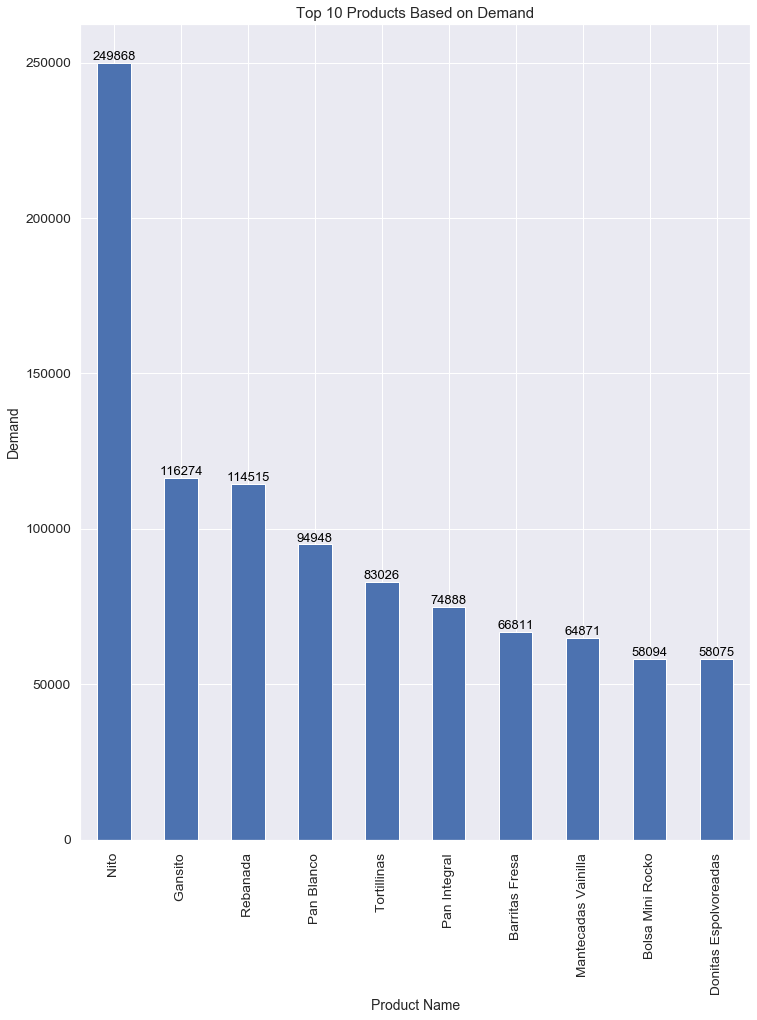

In [303]:
plt.figure(figsize = (12,15))

product_short_demand_test.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title("Top 10 Products Based on Demand")
plt.ylabel('Demand', fontsize=14) # y axis label
plt.xlabel('Product Name', fontsize=14) # x axis label

# Get current axis on current figure
ax = plt.gca()

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()),
           fontsize=13, color='black', ha='center', va='bottom')

plt.savefig("fig/Top10ProductsBasedonDemandInTest.png")